In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from ethos.constants import PROJECT_DATA, PROJECT_ROOT
from ethos.tokenize import SpecialToken, Vocabulary
from ethos.utils import load_model_from_checkpoint

In [3]:

model, _ = load_model_from_checkpoint(
    PROJECT_ROOT / "ethos/checkpoints/best_model.pt", "cpu", for_training=False,
    return_attention=True)
vocab = Vocabulary(PROJECT_DATA / "tokenized_datasets/mimic_vocab_t763.pkl")
q_tokens = vocab.encode(SpecialToken.DECILES)
time_tokens = vocab.encode(SpecialToken.SEPARATOR_NAMES).astype(int)
year_tokens = vocab.encode(SpecialToken.YEAR_NAMES).astype(int)

number of parameters: 45.87M


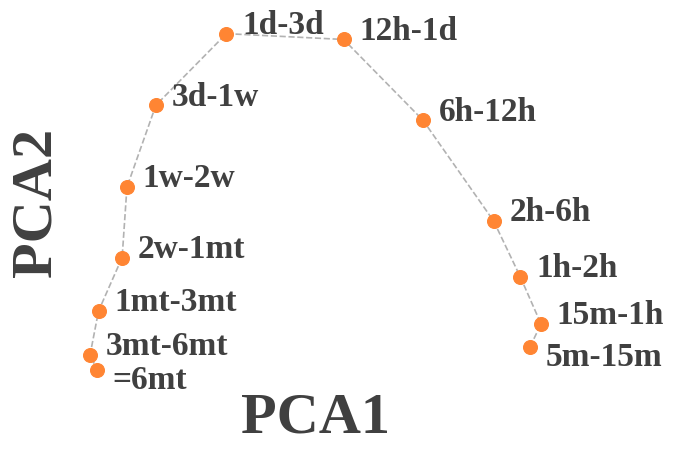

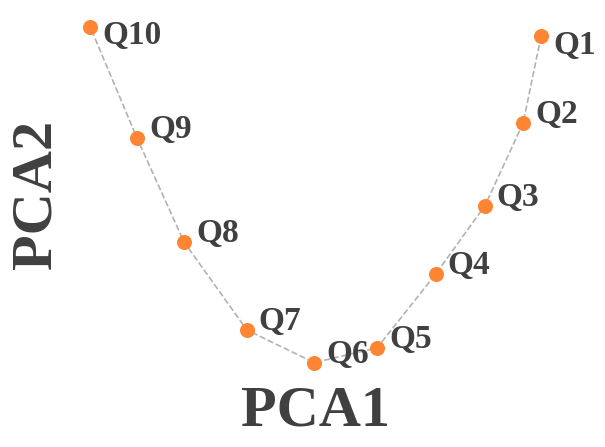

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

black_color = "#404040ff"
gray_color = "#b2b2b2ff"
orange_color = "#ff8533ff"
font_size = 42

sns.set(context="paper", style="white")

plt.rcParams['font.family'] = 'Liberation Serif'
plt.rcParams['text.color'] = black_color  # Set global text color using hex code
plt.rcParams['font.weight'] = 'bold'  # Set global font weight
plt.rcParams['axes.labelweight'] = 'bold'  # Set global weight for axis labels
plt.rcParams['axes.labelcolor'] = black_color  # Set global color for axis labels
plt.rcParams['xtick.color'] = black_color  # Set global color for xtick labels
plt.rcParams['ytick.color'] = black_color  # Set global color for ytick labels
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['axes.titleweight'] = 'bold'  # Make titles bold
plt.rcParams['axes.titlecolor'] = black_color
plt.rcParams['axes.labelsize'] = font_size

plot_data = [
    ("time_tokens", time_tokens, SpecialToken.SEPARATOR_NAMES),
    ("quantiles", q_tokens, SpecialToken.DECILES),
    # ("year_tokens", year_tokens, SpecialToken.YEAR_NAMES)
]

for name, tokens, labels in plot_data:
    token_weights = model.transformer.wte.weight[tokens].detach().numpy()
    coords = PCA(n_components=2, random_state=42).fit_transform(token_weights)
    x_vals, y_vals = coords.T

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(False)
    ax.set(xticks=[], yticks=[], xlabel="PCA1", ylabel="PCA2")
    ax.set_frame_on(False)

    ax.scatter(x_vals, y_vals, color=orange_color, s=100, zorder=10)
    ax.plot(x_vals, y_vals, color=gray_color, ls="--")

    for i, (x, y) in enumerate(zip(x_vals, y_vals)):
        label = labels[i][1:]
        y_offset = 0.04 if i in (0, len(x_vals) - 1) else 0
        ax.text(x + 0.03, y - y_offset, label, fontsize=24, color=black_color)

In [5]:
vocabulary = pd.DataFrame(vocab.stoi.items(), columns=["token", "group"])
vocabulary["group"] = np.nan
vocabulary.group = vocabulary.group.astype(object)
vocabulary.loc[lambda _df: _df.token.isin(SpecialToken.SEPARATOR_NAMES), "group"] = "time_intervals"
vocabulary.loc[lambda _df: _df.token.isin(SpecialToken.DECILES), "group"] = "quantiles"
vocabulary.loc[lambda _df: _df.token.isin(SpecialToken.YEAR_NAMES), "group"] = "years"
vocabulary.loc[
    lambda _df: _df.token.str.startswith("_") & _df.group.isna(), "group"] = "special_token"
vocabulary.loc[lambda _df: _df.token.str.startswith("ICD_PCS"), "group"] = "procedure"
vocabulary.loc[
    lambda _df: _df.token.str.startswith("ICD") & _df.group.isna(), "group"] = "diagnosis"
vocabulary.loc[lambda _df: _df.token.str.startswith("ATC"), "group"] = "medication"
vocabulary.loc[lambda _df: _df.token.str.startswith("LAB"), "group"] = "lab"
vocabulary.loc[lambda _df: _df.token.str.startswith("TRANSFER"), "group"] = "transfer"
vocabulary.loc[62:851, "group"] = "admission"
vocabulary.loc[871:882, "group"] = "icu"
vocabulary.loc[lambda _df: _df.group.isna(), "group"] = "other"
vocabulary

,token,group
0,_5m-15m,time_intervals
1,_15m-1h,time_intervals
2,_1h-2h,time_intervals
3,_2h-6h,time_intervals
4,_6h-12h,time_intervals
...,...,...
758,LAB_STX4_no_unit,admission
759,LAB_Metamyelocytes_%,admission
760,LAB_Specific Gravity_,admission
761,"LAB_Creatine Kinase, MB Isoenzyme_ng/mL",admission


In [29]:
data_prop = DataProp.create("mimic", "test")
trans = IcdCmTranslation(data_prop)
coords = pd.DataFrame(coords, columns=["x", "y"], index=icd_prefix.index)
coords["token"] = icd_prefix.token
coords.token = coords.token.str[4:].map(trans.name_to_code).str[:1]
gen = (i for _ in range(0, 10) for i in range(0, 3))
coords["token_style"] = coords.token.map(dict(zip(coords.token.unique(), gen)))
coords

,x,y,token,token_style
853,21.231718,11.015874,Z,0
854,24.301958,20.756155,I,1
855,30.346895,24.366861,F,2
858,21.526115,34.184845,B,0
859,35.866776,28.909206,Z,0
...,...,...,...,...
958,-2.503749,-2.580223,K,0
959,-1.896370,11.320349,K,0
961,-8.086876,16.479397,R,2
964,-6.543924,-31.677317,Q,2


[[], [], Text(0.5, 0, 't-SNE1'), Text(0, 0.5, 't-SNE2')]

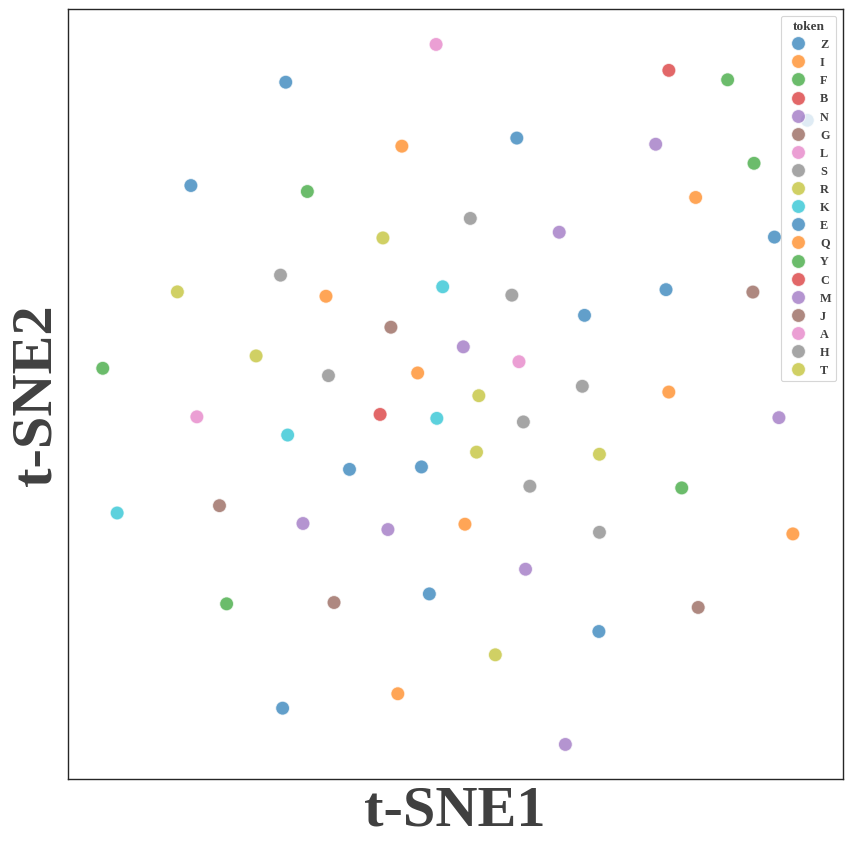

In [30]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=coords, x="x", y="y", hue="token",
                     palette="tab10", s=100, alpha=0.7)
ax.set(xticks=[], yticks=[], xlabel="t-SNE1", ylabel="t-SNE2")